# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os

# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [2]:
citiesdf = pd.read_csv("output_data/cities.csv")
citiesdf

,Unnamed: 0,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,cockburn town,21.4612,-71.1419,77.95,72,0,9.44,TC,1643485578
1,1,ucluelet,48.9329,-125.5528,43.09,89,100,1.01,CA,1643485562
2,2,dingle,10.9995,122.6711,74.71,91,9,1.57,PH,1643485640
3,3,casa nova,-9.4167,-41.1333,82.38,74,99,6.58,BR,1643485640
4,4,terrace,54.5163,-128.6035,39.11,93,100,21.85,CA,1643485514
...,...,...,...,...,...,...,...,...,...,...
564,564,lenine,45.2986,35.7771,34.23,82,85,11.83,UA,1643486498
565,565,misratah,32.3754,15.0925,57.15,57,100,21.21,LY,1643486498
566,566,hovd,48.0056,91.6419,-13.02,72,13,3.09,MN,1643486498
567,567,talara,-4.5772,-81.2719,75.33,72,100,12.48,PE,1643486499


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [3]:
# Configure gmaps
gmaps.configure(api_key=g_key)

In [33]:
locations = citiesdf[["Lat", "Lng"]]
humidity=citiesdf["Humidity"]

In [38]:
# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=humidity, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=3)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

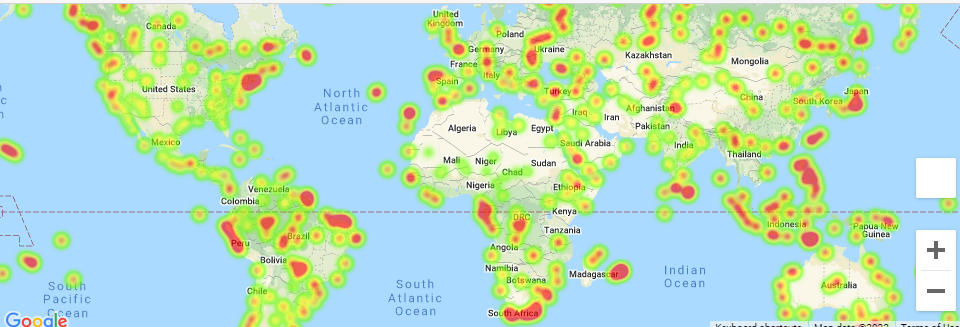

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [6]:
#A max temperature lower than 80 degrees but higher than 70.
#Wind speed less than 10 mph.
#Zero cloudiness.
#Drop any rows that don't contain all three conditions. You want to be sure the weather is ideal.

filter1=citiesdf.loc[(citiesdf["Max Temp"]<80) & (citiesdf["Max Temp"]>70)]
filter2=filter1.loc[filter1["Wind Speed"]<10]
bestweather=filter2.loc[filter2["Cloudiness"]==0]

bestweather=bestweather.drop(columns=["Unnamed: 0"]).dropna()
bestweather

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,cockburn town,21.4612,-71.1419,77.95,72,0,9.44,TC,1643485578
48,salalah,17.0151,54.0924,73.49,68,0,4.61,OM,1643485655
99,geraldton,-28.7667,114.6000,70.21,88,0,4.61,AU,1643485651
242,makakilo city,21.3469,-158.0858,76.60,61,0,3.44,US,1643485963
304,lima,-12.0432,-77.0282,75.45,85,0,1.99,PE,1643486104


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [7]:
hotel_df=pd.DataFrame()
hotel_df["Hotel Name"]=""
hotel_df["Lat"]=""
hotel_df["Lng"]=""
hotel_df["City"]=""
hotel_df["Country"]=""

In [29]:
#Using Google Places API to find the first hotel for each city located within 5000 meters of your coordinates.

base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

for index, row in bestweather.iterrows():
    
    #set up parameters for search
    params={
        "location": str(row["Lat"])+","+str(row["Lng"]), #coordinate of row 
        "type":'hotel',
        "radius":5000,
        "key":g_key
    }
    
    hotelinfo = requests.get(base_url, params=params).json()
    
    hotel_df.loc[index, "Hotel Name"] = hotelinfo["results"][1]["name"]
    hotel_df.loc[index, "Lat"] = hotelinfo["results"][1]["geometry"]["location"]['lat']
    hotel_df.loc[index, "Lng"] = hotelinfo["results"][1]["geometry"]["location"]['lng']
    hotel_df.loc[index, "City"] = hotelinfo["results"][0]["name"]
    hotel_df.loc[index, "Country"] = row["Country"]

hotel_df
#Plot the hotels on top of the humidity heatmap with each pin containing the **Hotel Name**, **City**, and **Country**.

,Hotel Name,Lat,Lng,City,Country
0,Osprey Beach Hotel,21.459551,-71.147430,Cockburn Town,TC
48,"HAMDAN PLAZA HOTEL SALALAH, an HTG Hotel",17.019113,54.061124,Salalah,OM
99,Broadwater Mariner Resort,-28.749328,114.619364,Geraldton,AU
242,Wet 'n' Wild Hawaii,21.334820,-158.087621,Kapolei,US
304,Gran Hotel Bolivar Lima,-12.050961,-77.035140,Lima,PE


In [35]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations2 = hotel_df[["Lat", "Lng"]]

In [40]:
# Add marker layer ontop of heat map

# Create marker layer
marker_layer = gmaps.marker_layer(
    locations2,
    info_box_content=hotel_info
)



# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=humidity, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=3)


# Add layer

fig.add_layer(heat_layer)
fig.add_layer(marker_layer)

fig
# Display figure



Figure(layout=FigureLayout(height='420px'))

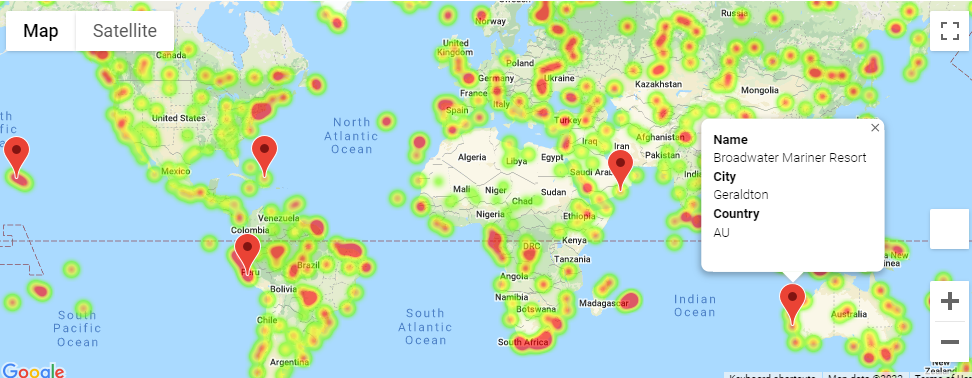
